#  IBM/Coursera Capstone Project - The Battle of the Neighborhoods
### Explore similar neighborhoods between Manhattan and Seattle
**Ray Wong**  
**2019 Aug.26 @ Kobe, Japan**


## Table of contents
* <u>Introduction</u>
* <u>Data</u>
* <u>Methodology</u>
* <u>Analysis</u>
* <u>Results and Discussion</u>
* <u>Conclusion</u>

## Introduction
We make decisions everyday, big or small, right or wrong. And every decision we made, makes us who we are.   
In year 1994, a 30-year-old young man decided to leave his lucrative job on Wall Street. He drove across the country all the way to Seattle and started an online bookstore. He named it Amazon. And the young man is Jeff Bezos. As he revealed later, he made this decision because of a report forecasting the rapid growth of Internet, also because of the fear of regret later in life.  

Today due to the gold rush of AI, there is an urgent need for qualified IT talents. Many smart minds, including those Wall Street workers of course, may be thinking about starting a new career in one of those cities full of tech giants. But transferring to a new career, moving to a new city itself is already very challenging, of course we would hope the new neighborhood we are moving to is similar to the one that we have been living in, so that it won't take us too long  and too much to adapt to the new environment.  

In this project, we are trying to solve such a problem. We are going to to explore the similarity between neighborhoods in Manhattan and Seattle, trying to come up with some insights as a reference to which neighborhood in Seattle should one choose if he is moving from a neighborhood in Manhattan to Seattle. 

To complete this task, we are going to use Foursquare location data to get the most common venue categories in each neighborhood and then based on this we will group the neighborhoods in clusters with k-means clustering Machine Learning Algorithm, and present the clustering result on a map generated with Folium library.

You may wonder why Seattle, why not Silicon Valley. Well, not only just because it is the headquarter of Amazon(one member of the 1 trillion dollar club), it is also the headquarter of Microsoft(another member of the 1 trillion dollar club), Zillow, Tableau, Expedia, etc. Other big tech companies like Google, Facebook, Twitter all have offices in Seattle. What's more, the living cost, especially the housing price is so friendly if compared with that in Silicon Valley. Not to mention the first Starbucks in Pike Place could be a big attraction to the coffee fun. Actually, even Starbucks is actively using AI, especially data science to strengthen its power. So if you are one of those Talents, make sure you take Seattle as an option before you make you decision.

## Data
For this project, we will need to collect dataset below:

- Manhattan neighborhood data with latitude and longitude coordinates

- Seattle neighborhood data with latitude and longitude coordinates

- Foursquare location data: Most common categories

### Manhattan neighborhood data
First we need the data of all neighborhoods in Manhattan, the coordinates of each neighborhood is also required since we will need to get the most common venue categories nearby each neighborhood with the coordinates.

Luckily, we can find the the data of New York on link below [https://geo.nyu.edu/catalog/nyu_2451_34572](https://geo.nyu.edu/catalog/nyu_2451_34572)

On the right of the page we could download the file in different format, Shapefile, KMZ, GeoJSON, we will download a file in GeoJSON format and then read the data we need (borough, neighborhood, latitude, longitude) into a pandas dataframe.

Since this data is for the whole New York, we will filter to get a subset of the neighborhoods of borough Manhattan only.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import requests
import json
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
%matplotlib inline

#### Collecting New York Neighborhood data

In [2]:
# load the new york neighborhood data
with open('ny_data.json') as json_data:
    ny_data = json.load(json_data)

Through a glance at the json data, We notice that the info. we need are stored in the 'featuers' key.
We will define a new variable neighborhood_data to include all the values under 'fearures' key.

In [3]:
neighborhood_data = ny_data['features']

In [4]:
# explore the first neighborhood in neighborhood_data
neighborhood_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Now let's have a look at the first neighborhood in our neighborhood data.

We can see that the coordinate info is stored in ['geometry']['coordinates'], but the order is [longitude, latitude].
The name of borough is stored in ['properties']['borough'].  
The name of the neighborhood is stored in ['properties']['name']  

Next we will create an empty dataframe called 'ny_df' with columns 'Borough', 'Neighborhood', 'Latitude', 'Longitude'and use a for loop to fill in the values of neighborhood.

We will print out the first 5 rows of the ny_df dataframe.

In [5]:
#  create an empty dataframe
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
ny_df = pd.DataFrame(columns = column_names)
# ny_df.head()

In [6]:
# use a for loop to fill in the values
for data in neighborhood_data:
    borough = data['properties']['borough']
    neighborhood = data['properties']['name'] 
    coordinates = data['geometry']['coordinates']
    latitude = coordinates[1]
    longitude = coordinates[0]
    ny_df = ny_df.append({'Borough': borough,
                        'Neighborhood': neighborhood,
                        'Latitude': latitude,
                        'Longitude': longitude}, ignore_index=True)
    

In [7]:
# first 5 rows
ny_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Collecting Manhattan Neighborhood data
The first 5 rows of ny_df dataframe looks good, next we will filter the 'Borough' column in the dataframe to get a subset of Manhattan, we will name it 'mh_neigh' and print out the first 5 rows.

In [8]:
# subset of Manhattan
mh_neigh = ny_df[ny_df.Borough == 'Manhattan'].reset_index(drop=True)
# first 5 rows 
mh_neigh.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Since we will need to merge all the neighborhoods from Manhattan and Seattle together later, we will change the column name 'Borough' to 'Borough/City' so that we could use the same column to store both the value of Manhattan Borough and Seattle City.

In [9]:
mh_neigh.rename(columns = {'Borough': 'Borough/City'}, inplace=True)
mh_neigh.head()

,Borough/City,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Double check values of column 'Borough'

In [10]:
mh_neigh['Borough/City'].value_counts()

Manhattan    40
Name: Borough/City, dtype: int64

Size of dataframe

In [11]:
size = mh_neigh.shape
print('The mh_neigh dataframe has {} rows with {} columns.'.format(size[0], size[1]))

The mh_neigh dataframe has 40 rows with 4 columns.


Check missing values

In [12]:
# check missing value
mh_neigh.isnull().sum()

Borough/City    0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

Check duplicates

In [13]:
#duplicates
mh_neigh.duplicated().sum()

0

Double check basic info. of the dataframe

In [14]:
# basic info
mh_neigh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
Borough/City    40 non-null object
Neighborhood    40 non-null object
Latitude        40 non-null float64
Longitude       40 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.3+ KB


Looks good, there is no missing value, no duplicates, all the data types are correct, let's save it to a csv file and name it 'manhattan_neighborhood.csv'.

In [15]:
mh_neigh.to_csv('manhattan_neighborhood.csv')

### Seattle neighborhood data 
We did not find any dataset with Seattle neighborhoods as well as coordinates, there is also hardly a webpage from where we could scrape all these info.  
In this case, we will have to divide this task into 3 steps:

1.  Get a dataset with Seattle neighborhood and zip code info.
- Get a dataset with Seattle coordinates and zip code info.
- Joint the 2 datasets above together 

####  Get a dataset with Seattle neighborhood and zip code info

We can get such info. from [Sub-Regional, City and Neighborhood Designations by Zip Code file](http://www.agingkingcounty.org/wp-content/uploads/sites/185/2016/09/SubRegZipCityNeighborhood.pdf)

But seems like some neighborhoods are not correct, we will modify the incorrect info. based on resources we get from some other website, like [seattle area](http://seattlearea.com/zip-codes/).

Considering that, Redmond, where The headquarter of Microsoft is located, is also a big attraction to the IT talents, and it is not far away from Seattle, we will also include Redmond in our dataset.

And then we get a working neighbborhood dataset in excel file. We will load the dataset to have a look at it.

In [16]:
# load the dataset of neighborhood and zip code
sea_neigh = pd.read_excel('SubRegZipCityNeighborhood.xlsx')
sea_neigh.head()

,ZIP,City,Neighborhood
0,98052,Redmond,Redmond
1,98101,Seattle,"Central Business District, First Hill"
2,98102,Seattle,Capitol Hill
3,98103,Seattle,"Greennwood, Freemont, Greenlake"
4,98104,Seattle,"Pioneer Square, International District"


#### Get a dataset with Seattle coordinates and zip code info

We can get this dataset on [United States Zip Codes](https://www.unitedstateszipcodes.org/wa/#zips-list).  
We will load the data below to explore the dataset.

In [17]:
#  load the dataset of coordinates and check the first 5 rows
df = pd.read_csv('zip_code_database.csv')
df.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


We can see that there are a lot of columns in the dataset that we don't need, we will just get a subset dataframe.

Let's again print out the first 5 rows.

In [18]:
# select 'zip', 'primary_city', 'county', 'latitude', 'longitude' columns
df = df[['zip', 'primary_city', 'county', 'latitude', 'longitude']]

In [19]:
#Seattle and Redmond are in King County, so let's take a look at the subset of King County 
df = df[df.county == 'King County']
#df['primary_city'].value_counts()

In [20]:
# get a subset of Seattle and Redmond
df = df[df['primary_city'].isin (['Seattle', 'Redmond'])]
# df.head()

In [21]:
# drop'primary_city' and 'county' column, reset index and rename columns to be consistent with 
# the Manhattan neighborhood dataset
df.drop(columns = ['primary_city', 'county'], axis=1, inplace=True)
df.reset_index(drop=True)
df.rename(columns = {'zip':'ZIP', 'latitude': 'Latitude', 'longitude':'Longitude' }, inplace=True)
df.head()

,ZIP,Latitude,Longitude
41670,98052,47.68,-122.12
41671,98053,47.66,-122.01
41687,98073,47.67,-122.11
41697,98101,47.61,-122.33
41698,98102,47.63,-122.32


#### Joint the 2 datasets

Joint the 2 datasets above together to get a dataset of Seattle neighborhoods with coordinates info.

In [22]:
# join the two dataset above
sea_neigh = sea_neigh.merge(df, how = 'left', on = 'ZIP')
sea_neigh.head()

,ZIP,City,Neighborhood,Latitude,Longitude
0,98052,Redmond,Redmond,47.68,-122.12
1,98101,Seattle,"Central Business District, First Hill",47.61,-122.33
2,98102,Seattle,Capitol Hill,47.63,-122.32
3,98103,Seattle,"Greennwood, Freemont, Greenlake",47.67,-122.34
4,98104,Seattle,"Pioneer Square, International District",47.60,-122.32


Check value counts of neighborhoods

In [23]:
sea_neigh.Neighborhood.value_counts()

Downtown                                  10
Northeast                                  4
Southwest                                  3
Northwest                                  3
Ballard                                    2
Delridge                                   2
Belltown                                   1
Northgate                                  1
South Lake Union, East Queen Anne          1
Redmond                                    1
University District,  Laurelhurst          1
Rainier Valley, Columbia City              1
Industrial District                        1
Greennwood, Freemont, Greenlake            1
Madison Park, Capitol Hill                 1
Capitol Hill                               1
Central Business District, First Hill      1
Broadview                                  1
Central                                    1
Duwamish                                   1
N. Beacon Hill, Mt. Baker                  1
Beacon Hill                                1
Queen Anne

We can see that while one zip code may encompass more than one neighborhood, one neighborhood may also contain multiple zip codes. We will group by the neighborhood, assign the mean value of coordinates of the neighborhood to the latitude and longitude variable, then we get a new dataframe.

In [24]:
sea_neigh = sea_neigh.groupby(['Neighborhood'])[['Latitude', 'Longitude']].mean().reset_index()
sea_neigh.head()

,Neighborhood,Latitude,Longitude
0,Ballard,47.675,-122.38
1,Beacon Hill,47.540,-122.31
2,Belltown,47.620,-122.35
3,Broadview,47.730,-122.37
4,Capitol Hill,47.630,-122.32


We will add a column 'Borough/City' to the dataset and assign 'Seattle' to the values of the column.

In [25]:
# add a new column 'Borough/City'
sea_neigh.insert(0, 'Borough/City', 'Seattle')

In [26]:
sea_neigh['Borough/City'] = 'Seattle'
sea_neigh.head()

,Borough/City,Neighborhood,Latitude,Longitude
0,Seattle,Ballard,47.675,-122.38
1,Seattle,Beacon Hill,47.540,-122.31
2,Seattle,Belltown,47.620,-122.35
3,Seattle,Broadview,47.730,-122.37
4,Seattle,Capitol Hill,47.630,-122.32


Size of the dataframe

In [27]:
sea_size = sea_neigh.shape
print('The sea_neigh dataframe has {} rows with {} columns.'.format(sea_size[0], sea_size[1]))

The sea_neigh dataframe has 26 rows with 4 columns.


Check missing values

In [28]:
# check missing values
sea_neigh.isnull().sum()

Borough/City    0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

Check duplicates

In [29]:
# check duplicates
sea_neigh.duplicated().sum()

0

Check basic info of the dataframe

In [30]:
# check basic info
sea_neigh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 4 columns):
Borough/City    26 non-null object
Neighborhood    26 non-null object
Latitude        26 non-null float64
Longitude       26 non-null float64
dtypes: float64(2), object(2)
memory usage: 912.0+ bytes


It looks good, no missing value, no duplicates, all the data types are correct, we will save it to a csv file named 'seattle_neighborhood.csv'.

In [31]:
sea_neigh.to_csv('seattle_neighborhood.csv')

### Merged Manhattan and Seattle neighborhood data
Since in this project we are going to do clustering on the neighborhoods of both Manhattan and Seattle, we will need to merge the two dataset together to get a new working dataset.

#### Load manhattan neighborhood data and seattle neighborhood data

In [32]:
# load manhattan neighborhood data
manh = pd.read_csv('manhattan_neighborhood.csv', index_col = 0)
manh.head()

,Borough/City,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [33]:
# load seattle neighborhood data
sea = pd.read_csv('seattle_neighborhood.csv', index_col = 0)
sea.head()

,Borough/City,Neighborhood,Latitude,Longitude
0,Seattle,Ballard,47.675,-122.38
1,Seattle,Beacon Hill,47.540,-122.31
2,Seattle,Belltown,47.620,-122.35
3,Seattle,Broadview,47.730,-122.37
4,Seattle,Capitol Hill,47.630,-122.32


#### Merge the Manhattan neighborhood data and Seattle neighborhood data

In [34]:
# merge the two dataset and check the size of the new dataset
mh_sea = pd.concat([manh, sea], sort=False).reset_index(drop=True)
mh_sea.head()

,Borough/City,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Check size of the merged dataset

In [35]:
# check size of the dataset
mh_sea_size = mh_sea.shape

print('The merged mh_sea dataset has {} rows with {} columns.'.format(mh_sea_size[0], mh_sea_size[1]))

The merged mh_sea dataset has 66 rows with 4 columns.


check missing values

In [36]:
# check missing values
mh_sea.isnull().sum()

Borough/City    0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

Check duplicates

In [37]:
# check duplicated
mh_sea.duplicated().sum()

0

Check basic info. of the dataset

In [38]:
# basic info
mh_sea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 4 columns):
Borough/City    66 non-null object
Neighborhood    66 non-null object
Latitude        66 non-null float64
Longitude       66 non-null float64
dtypes: float64(2), object(2)
memory usage: 2.1+ KB


The merged working dataset looks good, no missing values, no duplicates, all data types are correct. We will save it to a csv file for later use.

In [39]:
mh_sea.to_csv('manhattan_seattle_neighborhood.csv')

### Foursquare location data
After we get the working data of Manhattan neighborhoods and Seattle neighborhoods, we could use Foursquare API to get the most common venue categories nearby each neighborhood in Manhattan and Seattle. And then group the neighborhood in clusters based on the most common venue categories with k-mean clusters Machine Learning Algorithm.
For generating the nearby venues, we will choose a radius of 1km and limit to the top 100 venues.

#### To start up with Foursquares, we will define Foursquare Credentials and Version first

In [40]:
# Define Foursquare Credentials and Version
CLIENT_ID = '1QLDTWGYGVIST1KCL0TY0ADVUHPVTDIUGLAFXPIWOQZEXNWW' # your Foursquare ID
CLIENT_SECRET = '2QP3AWK3ACZVGBULSKRPG0HS50ZM4MZ2VXVXQDA44FR1H0FZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1QLDTWGYGVIST1KCL0TY0ADVUHPVTDIUGLAFXPIWOQZEXNWW
CLIENT_SECRET:2QP3AWK3ACZVGBULSKRPG0HS50ZM4MZ2VXVXQDA44FR1H0FZ


#### Now let's get the top 100 venues within 1km for each neighborhood

In [41]:
# function to loop each neighborhood and get the 100 venues within 1km.
def getNearbyVenues(cities, names, latitudes, longitudes, radius=1000, LIMIT = 100):
    
    venues_list=[]
    for city, name, lat, lng in zip(cities, names, latitudes, longitudes):  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City/Borough', 'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [42]:
# Load the working dataset 
mh_sea = pd.read_csv('manhattan_seattle_neighborhood.csv', index_col = 0)
# mh_sea.head()

In [43]:
# run the function above to get nearby venues for each neighborhood
venues = getNearbyVenues(cities=mh_sea['Borough/City'],
                        names=mh_sea['Neighborhood'],
                        latitudes=mh_sea['Latitude'],
                        longitudes=mh_sea['Longitude']
                                  )

In [44]:
# first 5 row 
venues.head()

,City/Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Manhattan,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Manhattan,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Manhattan,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
4,Manhattan,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


Size of the venues dataset

In [45]:
# size of venues dataset
ven_size = venues.shape
print('The venues dataset has {} rows and {} columns.'.format(ven_size[0], ven_size[1]))

The venues dataset has 5605 rows and 8 columns.


Missing values

In [46]:
# check missing value
venues.isnull().sum()

City/Borough              0
Neighborhood              0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Venue Category            0
dtype: int64

Duplicates

In [47]:
# check duplicates
venues.duplicated().sum()

0

Basic Info. of the venues dataset

In [48]:
# basic info
venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5605 entries, 0 to 5604
Data columns (total 8 columns):
City/Borough              5605 non-null object
Neighborhood              5605 non-null object
Neighborhood Latitude     5605 non-null float64
Neighborhood Longitude    5605 non-null float64
Venue                     5605 non-null object
Venue Latitude            5605 non-null float64
Venue Longitude           5605 non-null float64
Venue Category            5605 non-null object
dtypes: float64(4), object(4)
memory usage: 350.4+ KB


This dataset looks good, it has the info. we need, with no missing value, no duplicates. And the data types look good. We will save it to a csv file called 'nearby_venues.csv'.

In [49]:
# save the dataset for later use
venues.to_csv('nearby_venues.csv')

## Methodology

In this project, we are trying to explore the similarity between neighborhoods in Manhattan and Seattle.

The stakeholders of this project would be talents living in Manhattan who are thinking about starting a new IT career(especially AI) in Seattle.

To complete this task, we will do the following steps in this project:

- Collecting data: Including Manhattan neighborhood data, Seattle Neighborhood data, venues nearby each neighborhood which will be generated by Foursquare API.
- Exploratory data analysis to better understand our working dataset
- Creating Map of Manhattan and map of Seattle with Folium library.
- Clustering of the neighborhoods: We will use K means clustering machine learning algorithm since it is fast and especially when there are too many variables.
- Presenting the clustering result on the map 

## Analysis
### Exploratory Data Analysis
In the section, we will load and the nearby venues data and do an exploratory data analysis on it.

In [50]:
# load the nearby venues data and check the first 5 rows
venues = pd.read_csv('nearby_venues.csv', index_col = 0)
#venues.head()

#### Neighborhoods

First we will check whether the venues dataset has venues for all 66 neighborhoods, 40 in Manhattan and 26 in Seattle.

In [51]:
# check how many neighborhoods we successfully got venues from.
n = len(venues.Neighborhood.unique())
print('The venues dataset has venues for {} unique neighborhoods.'.format(n))

The venues dataset has venues for 66 unique neighborhoods.


In [52]:
# check in the dataset whether there are 40 neighborhoods in Manhattan 
# and 26 in Seattle as is supposed to be 
n_mh = len(venues[venues['City/Borough']=='Manhattan'].Neighborhood.unique())
n_sea = len(venues[venues['City/Borough']=='Seattle'].Neighborhood.unique())

print('The dataset has {} unique neighborhoods in Manhattan and {} unique neighborhoods in Seattle'.format(n_mh, n_sea))

The dataset has 40 unique neighborhoods in Manhattan and 26 unique neighborhoods in Seattle


#### Venues

First Let's have a look at how many venues are returned for each neighbohood

In [53]:
# check how many venues are returned for each neighborhood
venue_count = venues.groupby(['City/Borough', 'Neighborhood']).count().reset_index()
venue_count

,City/Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan,Battery Park City,100,100,100,100,100,100
1,Manhattan,Carnegie Hill,100,100,100,100,100,100
2,Manhattan,Central Harlem,100,100,100,100,100,100
3,Manhattan,Chelsea,100,100,100,100,100,100
4,Manhattan,Chinatown,100,100,100,100,100,100
5,Manhattan,Civic Center,100,100,100,100,100,100
6,Manhattan,Clinton,100,100,100,100,100,100
7,Manhattan,East Harlem,100,100,100,100,100,100
8,Manhattan,East Village,100,100,100,100,100,100
9,Manhattan,Financial District,100,100,100,100,100,100


Foursquare API returned 100 venues for most of the neighborhoods, but returned less than 100 venues for some of the neighborhoods, we will take a look at which neighborhood does not have 100 venues.

In [54]:
venue_count[venue_count.Venue != 100]

,City/Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
22,Manhattan,Marble Hill,84,84,84,84,84,84
41,Seattle,Beacon Hill,20,20,20,20,20,20
43,Seattle,Broadview,4,4,4,4,4,4
44,Seattle,Capitol Hill,80,80,80,80,80,80
45,Seattle,Central,64,64,64,64,64,64
47,Seattle,Delridge,22,22,22,22,22,22
49,Seattle,Duwamish,56,56,56,56,56,56
50,Seattle,"Greennwood, Freemont, Greenlake",86,86,86,86,86,86
51,Seattle,Industrial District,56,56,56,56,56,56
52,Seattle,"Madison Park, Capitol Hill",52,52,52,52,52,52


Size of vanue_count dataframe

In [55]:
venue_count[venue_count.Venue != 100].shape

(19, 8)

There are 19 neighborhoods have less than 100 venues, some neighborhoods even only have less than 10 venues returned. Among these 19 neighborhoods, one is from Manhattan, the other 18 are from Seattle. This may impact our clustering to some extent, to reduce this impact, we will only use the top 10 categories for clustering.

#### Categories
Next we all explore the venue categories returned by Foursquare API.

How many unique categories are returned in total?

In [56]:
# find out how many unique categories are returned.
num_cat = len(venues['Venue Category'].unique())
print('There are {} uniques categories.'.format(num_cat))

There are 376 uniques categories.


How many unique categories for Manhattan and Seattle?

In [57]:
# venue categories by City(Borough)
mh_cat = venues[venues['City/Borough'] == 'Manhattan']['Venue Category'].unique()
num_mh_cat = len(mh_cat)
sea_cat = venues[venues['City/Borough'] == 'Seattle']['Venue Category'].unique()
num_sea_cat = len(sea_cat)
print('Manhattan has {} unique venue categories'.format(num_mh_cat))
print('Seattle has {} unique venue categories'.format(num_sea_cat))

Manhattan has 310 unique venue categories
Seattle has 267 unique venue categories


Visualize the top 10 categories

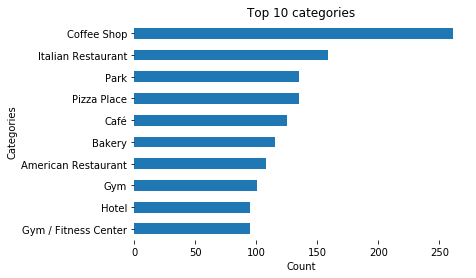

In [58]:
# top 10 categories
top10_cat = venues['Venue Category'].value_counts().head(10)
ax1 = top10_cat.plot(kind = 'barh', figsize = (6, 4))
ax1.set_title('Top 10 categories')
ax1.set_xlabel('Count')
ax1.set_ylabel('Categories')
ax1.invert_yaxis()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)


From the bar chart above, it is not difficult to figure out that most of the top 10 categories are related to Restaurant, Cafe that kind of stuff.

Visualize Bottom 10 categories

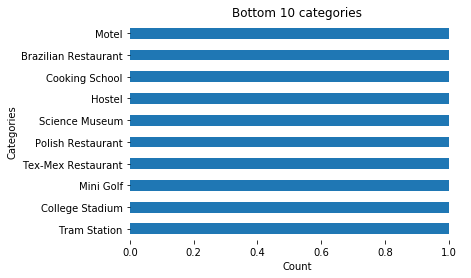

In [59]:
# bottom 10 categories
bottom10_cat = venues['Venue Category'].value_counts().tail(10)
ax2 = bottom10_cat.plot(kind = 'barh', figsize = (6, 4))
ax2.set_title('Bottom 10 categories')
ax2.set_xlabel('Count')
ax2.set_ylabel('Categories')
ax2.invert_yaxis()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

The bottom 10 categories all only have 1 count. Let's take a look at all those categories whose count is 1.

In [60]:
cat_count = venues['Venue Category'].value_counts().to_frame().reset_index()
cat_count.columns = ['Venue Category', 'Count']
cat_count[cat_count.Count == 1]['Venue Category'].unique()

array(['Zoo', 'Photography Studio', 'TV Station', 'Radio Station',
       'Post Office', 'North Indian Restaurant', 'Piano Bar',
       'Kebab Restaurant', 'Ukrainian Restaurant', 'Daycare', 'Locksmith',
       'Costume Shop', 'Storage Facility', 'Herbs & Spices Store',
       'Arcade', 'Irish Pub', 'Insurance Office', 'Metro Station',
       'Lighthouse', 'Pedestrian Plaza', 'Multiplex', 'Nature Preserve',
       'Board Shop', 'Fabric Shop', 'Modern European Restaurant',
       'Tour Provider', 'Volleyball Court', 'Ski Area',
       'Spiritual Center', 'Outdoors & Recreation', 'Church',
       'Veterinarian', 'Bed & Breakfast', 'Gay Bar', 'Synagogue', 'River',
       'Heliport', 'Bowling Alley', 'Construction & Landscaping',
       'Swiss Restaurant', 'Malay Restaurant', 'Child Care Service',
       'Dry Cleaner', 'Indonesian Restaurant', 'Cantonese Restaurant',
       'Laundry Service', 'Basketball Stadium', 'Neighborhood',
       'Bus Line', 'Sports Club', 'Tennis Stadium',
       '

Ok, that's pretty much it about the exploratory analysis, next let's dive deeper into the dataset.

### Top 10 categories for each Neighborhood

In this section, we will first use the one hot encoding to each categories into a separate column and calculate the frequency of occurrence of each category.
Then we will slice the top 10 categories for clustering.

One hot encoding

In [61]:
# one hot encoding
mhsea_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add 'Neighborhood' column and 'City/borough' column back to dataframe
mhsea_onehot['Neighborhood'] = venues['Neighborhood'] 

# move 'Neighborhood' column to the first column
Neighborhood = mhsea_onehot.pop('Neighborhood')
mhsea_onehot.insert(0, 'Neighborhood', Neighborhood)
mhsea_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Frequency of occurrence of each category

In [62]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
mhsea_grouped = mhsea_onehot.groupby('Neighborhood').mean().reset_index()
mhsea_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Ballard,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0
1,Battery Park City,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.03,0.0,...,0.0,0.0,0.0,0.04,0.0,0.0,0.01,0.0,0.0,0.0
2,Beacon Hill,0.00,0.0,0.0,0.0,0.1,0.15,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0
3,Belltown,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0
4,Broadview,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0


Top 10 categories for each neighborhood

In [63]:
#write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
# create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mhsea_grouped['Neighborhood']

n_grouped = mhsea_grouped.shape[0]
for ind in range(n_grouped):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mhsea_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballard,Coffee Shop,Ice Cream Shop,Mexican Restaurant,Bakery,Burger Joint,Gym,Cocktail Bar,Thai Restaurant,Vietnamese Restaurant,Pizza Place
1,Battery Park City,Park,Coffee Shop,Wine Shop,Gym,American Restaurant,Plaza,Memorial Site,Gym / Fitness Center,Scenic Lookout,Dog Run
2,Beacon Hill,Airport Terminal,Café,Airport,Fried Chicken Joint,Sandwich Place,French Restaurant,Brewery,Gas Station,Miscellaneous Shop,Soccer Field
3,Belltown,Coffee Shop,Exhibit,Pizza Place,Bar,Sculpture Garden,Vietnamese Restaurant,Mexican Restaurant,Movie Theater,Gym,Music Venue
4,Broadview,Trail,Golf Course,Concert Hall,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field


### Use K means to Cluster Neighborhoods into 5 clusters on map

In this section, we will first create maps for Manhattan and Seattle, do the k means clustering and then superimpose the clustering result on the maps of Manhattan and Seattle to for visualization.

#### Map of Manhattan
First, let's get the coordinates of Manhattan, using the Nominatim Function.

In [65]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


Then we will create a map of Manhattan with folium library, set the zoom_start to be 11 so we have a good view of the whole Manhattan.

In [66]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
map_manhattan

#### Map of Seattle
With the same steps above, we will create another map for Seattle.  
First, let's get the coordinates of Seattle, using the Nominatim Function.  
Then we create a map of Seattle with folium library.

In [67]:
# get the coordinates of Seattle
address = 'Seattle, WA'
geolocator = Nominatim(user_agent="sea_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Seattle
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)
map_seattle

#### K Means clustering and visualization

Next we will use the k means clustering machine learning algorithm to cluster all the neighborhoods into 5 clusters and examine the clusters.

Set up k means clustering and check the first 10 cluster labels

In [68]:
# set up k means clustering
n = 5

mhsea_grouped_clustering = mhsea_grouped.drop('Neighborhood', 1)

kmeans = KMeans(init='k-means++', n_clusters=n, random_state=4).fit(mhsea_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 1, 3, 2, 1, 1, 3, 1, 1], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [69]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
mh_sea = pd.read_csv('manhattan_seattle_neighborhood.csv', index_col = 0)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mh_sea_merged = mh_sea.merge(neighborhoods_venues_sorted, on='Neighborhood')
mh_sea_merged.head()

,Borough/City,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Park,Pizza Place,Supermarket,Mexican Restaurant,Spanish Restaurant,Café,Donut Shop,Sandwich Place,Deli / Bodega,Coffee Shop
1,Manhattan,Chinatown,40.715618,-73.994279,1,Sandwich Place,Cocktail Bar,Café,Ice Cream Shop,Wine Bar,Bakery,Thai Restaurant,Coffee Shop,Dumpling Restaurant,Hotel
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Pizza Place,Latin American Restaurant,Bakery,Mexican Restaurant,Spanish Restaurant,Grocery Store,Café,Deli / Bodega,Tapas Restaurant,Park
3,Manhattan,Inwood,40.867684,-73.921210,3,Latin American Restaurant,Pizza Place,Deli / Bodega,Mexican Restaurant,Café,Wine Bar,Spanish Restaurant,Lounge,Bakery,Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Coffee Shop,Bar,Café,Mexican Restaurant,Ethiopian Restaurant,Yoga Studio,Sushi Restaurant,Park,Caribbean Restaurant,American Restaurant


Let's show the clusters on the map of Manhattan.

In [70]:
# clusters on map of Manhattan
# set color scheme for the clusters
x = np.arange(n)
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mh_sea_merged['Latitude'], mh_sea_merged['Longitude'], mh_sea_merged['Neighborhood'], mh_sea_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_manhattan)
map_manhattan

Let's show the clusters on the map of Seattle.

In [71]:
# Clusters on map of Seattle
# set color scheme for the clusters
x = np.arange(n)
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mh_sea_merged['Latitude'], mh_sea_merged['Longitude'], mh_sea_merged['Neighborhood'], mh_sea_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_seattle)
map_seattle

From the map above, we can see that the neighborhoods in Manhattan are all in two clusters, which is cluster 1 and cluster 3.

Next we will print out the list of cluster 1 and cluster 3 to have a look.

Cluster 1

In [72]:
# cluster 1
mh_sea_merged[mh_sea_merged['Cluster Labels'] == 1]

,Borough/City,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Manhattan,Chinatown,40.715618,-73.994279,1,Sandwich Place,Cocktail Bar,Café,Ice Cream Shop,Wine Bar,Bakery,Thai Restaurant,Coffee Shop,Dumpling Restaurant,Hotel
5,Manhattan,Manhattanville,40.816934,-73.957385,1,Park,Mexican Restaurant,Café,American Restaurant,Italian Restaurant,Seafood Restaurant,Theater,Tennis Court,Food Truck,Wine Shop
6,Manhattan,Central Harlem,40.815976,-73.943211,1,Southern / Soul Food Restaurant,African Restaurant,Café,Gym / Fitness Center,French Restaurant,Sushi Restaurant,Seafood Restaurant,American Restaurant,Bar,Public Art
8,Manhattan,Upper East Side,40.775639,-73.960508,1,Exhibit,Italian Restaurant,Gym / Fitness Center,Bakery,Coffee Shop,American Restaurant,French Restaurant,Hotel,Yoga Studio,Art Museum
9,Manhattan,Yorkville,40.775930,-73.947118,1,Italian Restaurant,Gym,Coffee Shop,Ice Cream Shop,Pizza Place,Gym / Fitness Center,Deli / Bodega,Wine Shop,Bagel Shop,Japanese Restaurant
10,Manhattan,Lenox Hill,40.768113,-73.958860,1,Sushi Restaurant,Italian Restaurant,Coffee Shop,Gym / Fitness Center,French Restaurant,Dessert Shop,Sporting Goods Shop,Gym,Pizza Place,Bakery
12,Manhattan,Upper West Side,40.787658,-73.977059,1,Italian Restaurant,Wine Bar,Ice Cream Shop,Indian Restaurant,Bakery,Vegetarian / Vegan Restaurant,Park,Cosmetics Shop,Coffee Shop,American Restaurant
13,Manhattan,Lincoln Square,40.773529,-73.985338,1,Coffee Shop,Gym / Fitness Center,Gym,Jazz Club,Italian Restaurant,French Restaurant,Plaza,Wine Bar,Concert Hall,Indie Movie Theater
14,Manhattan,Clinton,40.759101,-73.996119,1,Theater,Hotel,Coffee Shop,American Restaurant,Gym / Fitness Center,Burger Joint,Bar,Indie Theater,Wine Shop,Bakery
15,Manhattan,Midtown,40.754691,-73.981669,1,Theater,Gym,Hotel,Coffee Shop,Italian Restaurant,Bakery,Plaza,Sandwich Place,Cuban Restaurant,Chinese Restaurant


Cluster 3

In [73]:
# cluster 3
mh_sea_merged[mh_sea_merged['Cluster Labels'] == 3]

,Borough/City,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Park,Pizza Place,Supermarket,Mexican Restaurant,Spanish Restaurant,Café,Donut Shop,Sandwich Place,Deli / Bodega,Coffee Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Pizza Place,Latin American Restaurant,Bakery,Mexican Restaurant,Spanish Restaurant,Grocery Store,Café,Deli / Bodega,Tapas Restaurant,Park
3,Manhattan,Inwood,40.867684,-73.921210,3,Latin American Restaurant,Pizza Place,Deli / Bodega,Mexican Restaurant,Café,Wine Bar,Spanish Restaurant,Lounge,Bakery,Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Coffee Shop,Bar,Café,Mexican Restaurant,Ethiopian Restaurant,Yoga Studio,Sushi Restaurant,Park,Caribbean Restaurant,American Restaurant
7,Manhattan,East Harlem,40.792249,-73.944182,3,Café,Bakery,Pizza Place,Mexican Restaurant,Deli / Bodega,Plaza,Gym,Latin American Restaurant,Cocktail Bar,Italian Restaurant
11,Manhattan,Roosevelt Island,40.762160,-73.949168,3,Park,Coffee Shop,Sushi Restaurant,Pizza Place,Greek Restaurant,Café,Deli / Bodega,Mexican Restaurant,Salad Place,Liquor Store
19,Manhattan,East Village,40.727847,-73.982226,3,Wine Bar,Bar,Coffee Shop,Ice Cream Shop,Pizza Place,Cocktail Bar,Japanese Restaurant,Seafood Restaurant,Asian Restaurant,Bagel Shop
25,Manhattan,Manhattan Valley,40.797307,-73.964286,3,Coffee Shop,Park,Indian Restaurant,Ice Cream Shop,Grocery Store,Mexican Restaurant,Pizza Place,Chinese Restaurant,Latin American Restaurant,Bar
26,Manhattan,Morningside Heights,40.808000,-73.963896,3,Italian Restaurant,Coffee Shop,Park,American Restaurant,Bakery,Grocery Store,Mexican Restaurant,Seafood Restaurant,Bookstore,Thai Restaurant
28,Manhattan,Battery Park City,40.711932,-74.016869,3,Park,Coffee Shop,Wine Shop,Gym,American Restaurant,Plaza,Memorial Site,Gym / Fitness Center,Scenic Lookout,Dog Run


There are as many as 40 neighborhoods in Manhattan, we are not going to explore each of them, what we will do is:

On the internet, find out the top 3 popular neighborhoods in Manhattan.

Then check the similar neighborhoods in Seattle for those 3 neighborhoods

After doing some googling, we came up with our top 3 Manhattan Neighborhoods: East Village, West Village and Lower East Side, based on the webpages below:

- [Top 5 Neighborhoods for Wall Street Workers](https://www.careermetis.com/neighborhoods-for-wall-street-workers/)
- [Work in the Financial District? 5 great neighborhoods with a quick commute](https://www.brickunderground.com/blog/2015/10/30_minute_commute_financial_district)
- [The Top 10 New York City Neighborhoods to Live In, According to the Locals](https://www.forbes.com/sites/trulia/2016/10/04/the-top-10-new-york-city-neighborhoods-to-live-in-according-to-the-locals/#5a2079881494)


Let's check out which clusters are the three neighborhoods in.

In [74]:
# cluster of East Village 
clu_lab1 = mh_sea_merged[mh_sea_merged.Neighborhood == 'East Village']['Cluster Labels'].values
clu_lab1 = int(clu_lab1)
print('East Village Neighborhood is in cluster {}'.format(clu_lab1))

# cluster of West Village
clu_lab2 = mh_sea_merged[mh_sea_merged.Neighborhood == 'West Village']['Cluster Labels'].values
clu_lab2 = int(clu_lab2)
print('West Village Neighborhood is in cluster {}'.format(clu_lab2))

# cluster of Lower East Side
clu_lab3 = mh_sea_merged[mh_sea_merged.Neighborhood == 'Lower East Side']['Cluster Labels'].values
clu_lab3 = int(clu_lab3)
print('Lower East Side Neighborhood is in cluster {}'.format(clu_lab3))


East Village Neighborhood is in cluster 3
West Village Neighborhood is in cluster 1
Lower East Side Neighborhood is in cluster 1


OK, so East Village Neighborhood is in cluster 3, Lower East Side Neighborhood and West village Neighborhood are in cluster 1.

You can also double confirm this on the map. East Village Neighborhood is represented by green circles(cluster 2), while Lower East Side Neighborhood and West village Neighborhood are in purple(cluster 1).

Let's check which Seattle Neighborhoods are similar to East Village neighborhood, that is to say, in cluster 3; and which Seattle Neighborhoods are similar to Lower East Side and West Village neighborhood, which are in cluster 1.

In [75]:
# seattle neighborhoods in cluster 3
# first get a subset of only seattle neighborhoods from the merged dataset
sea_merged = mh_sea_merged[mh_sea_merged['Borough/City'] == 'Seattle']

# filter Cluster Labels column to get the seattle neighborhoods in cluster 2
sea_clu3 = sea_merged[sea_merged['Cluster Labels'] == 3]['Neighborhood'].unique()
print('If you are moving to Seattle from East Village in Manhattan, \nThe similar neighborhoods in Seattle that you could choose are:\n')
for neighborhood in sea_clu3:
    print(neighborhood)

If you are moving to Seattle from East Village in Manhattan, 
The similar neighborhoods in Seattle that you could choose are:

Ballard
Belltown
Central
Delridge
Greennwood, Freemont, Greenlake
N. Beacon Hill, Mt. Baker
Northgate
Northwest
Pioneer Square, International District
Queen Anne/Magnolia
Rainier Valley, Columbia City
Redmond
South Lake Union, East Queen Anne


In [76]:
# filter Cluster Labels column to get the seattle neighborhoods in cluster 1
sea_clu1 = sea_merged[sea_merged['Cluster Labels'] == 1]['Neighborhood'].unique()
print('If you are moving to Seattle from West Village or Lower East Side in Manhattan, \nThe similar neighborhoods in Seattle that you could choose are:\n ')
for neighborhood in sea_clu1:
    print(neighborhood)

If you are moving to Seattle from West Village or Lower East Side in Manhattan, 
The similar neighborhoods in Seattle that you could choose are:
 
Beacon Hill
Capitol Hill
Central Business District, First Hill
Downtown
Madison Park, Capitol Hill
Northeast
University District,  Laurelhurst


## Results and Discussion 

From the exploration above, we find that among the 5 clusters, Manhattan neighborhoods are all in 2  clusters, which is cluster 1 and cluster 3.

Since there are too many neighborhoods in Manhattan, we did not look deep into each one, instead we focused on the top three neighborhoods in Manhattan, which are:
- East Village Neighborhood
- Lower East Side Neighborhood
- West Village Neighborhood.

And we did find the similar neighborhood in Seattle for each of those 3 neighborhoods in Manhattan.

If you are interested in exploring some other certain neighborhood in Manhattan, you can just feel free to go back to the Manhattan map we generated and click on the circle which represent your interested neighborhood to find out the cluster and then go to the Seattle map to figure out the similar neighborhood in the same cluster(in the same color).

Or if you are a big fan of charts or lists, you can also check the cluster 1 and cluster 3 neighborhoods list we generated earlier to proceed.

And please be kindly noted that, although the result in our analysis could throw some insights onto the issue concerned, since our data are collected online from multiple sources, we should always be critical about the confidence of the result and only take as a reference.

## Conclusion

If this project, we are trying to find out the similar neighborhoods between Manhattan and Seattle, intend to provide an insight to those who would like to move from Manhattan to Seattle to start a new career.

And luckily, there do exist some neighborhoods in Seattle similar to those in Manhattan as shown above.

But it should also be well acknowledged that the result of this analysis is basically according to the categories of venues nearby the center of the neighborhood, there are some other factor you may also want to take into consideration before you make up your mind, things like weather, commuting, crime rate,  and so on.

Hope you had a good time through this journey of exploring similar neighborhoods.
